# **CLASSIFICATION**


*Classification of News articles into Categories*


Contributor Details

---


- Deeksha Spoorthi Sammidi 
- SJSU ID: 016626753
- Team 10 - Application Track


# Importing Necessary Libraries

Importing necessary libraries for the classification algorithms and models that are we are intending to use

In [ ]:
#import important libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

#Downloading Preprocessing and data cleaning modules
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

#EDA and preprocessing
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

#modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import itertools
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

#used this code initially when we uploaded files to Colab Runtime from local disk
#changed to another since it is taking long time
#find the files names
#for dirname, _, filenames in os.walk('/content/sample_data/News'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Loading




**Using Files From Google Drive on Google Colab**



- In general uploading files from local disk to google colab runtime environment takes very long duration.

- Inorder to reduce this uploading time, we use the code  ***! gdown id*** where "id" is the access ID in the link of the file that is uploaded on the drive with public access.

- This helps us in saving time by preventing user to upload files to runtime each time it gets disconnected.

In [ ]:
# uploading required files from google drive to google colab
! gdown 1OdA-xl-N_H5pIKx6tEFT561dTQIYDEyp
path_dir = '/content/'
train_path = path_dir + 'BBC News Train.csv'

! gdown 1jyyWh6Njq9HepMh4Ku8YDm7x7ovz0DGZ
projDataframe_path = path_dir + 'projDataframe.csv'

Downloading...
From: https://drive.google.com/uc?id=1OdA-xl-N_H5pIKx6tEFT561dTQIYDEyp
To: /content/BBC News Train.csv
100% 3.35M/3.35M [00:00<00:00, 190MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jyyWh6Njq9HepMh4Ku8YDm7x7ovz0DGZ
To: /content/projDataframe.csv
100% 53.7k/53.7k [00:00<00:00, 72.9MB/s]


**Importing Data:**

In [ ]:
train = pd.read_csv(train_path)
df=pd.read_csv(projDataframe_path)

In [ ]:
train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


Getting more information about the dataframe

In [ ]:
train.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [ ]:
train['ArticleId'].nunique()

1490

In [ ]:
train['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [ ]:
# first row 
train['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

# Data Visualization & Preprocessing

## Graph 1

### **Graph displaying the Number of articles of each category type in the training data set**


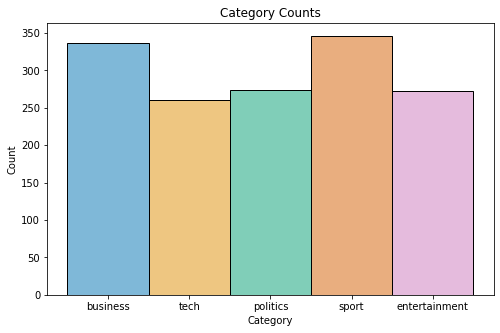

In [ ]:

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(
    data = train,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts');

## 3a. Removing Stopwords, Punctuation, Numbers & Extra Spaces

**Helper function to remove punctuation and stopwords by taking dataframe as input**

In [ ]:
def clean_text(dataframe, text_col):
    
    #to remove punctuation
    dataframe['no_punct'] = dataframe[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    #to remove numbers 
    dataframe['no_punct_num'] = dataframe['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    #to remove stopwords
    stop_words = stopwords.words('english')
    dataframe['no_stopwords'] = dataframe['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #to remove extra spaces
    dataframe['clean_text'] = dataframe['no_stopwords'].apply(lambda x: re.sub(' +', ' ', x))
    return

In [ ]:
#clean dataframe text column
clean_text(train, 'Text')

In [ ]:
train['clean_text'][1]

'german business confidence slides german business confidence fell february knocking hopes speedy recovery europe largest economy munichbased research institute ifo said confidence index fell february january first decline three months study found outlook manufacturing retail sectors worsened observers hoping confident business sector would signal economic activity picking surprised ifo index taken knock said dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement called dip february ifo confidence figure mild decline said despite retreat index remained relatively high level expected modest economic upswing continue germany economy grew last year shrinking however economy contracted last three months mainly due reluctance consumers spend latest indications growth still proving elusive ifo president hanswerner sinn said improvement german domestic demand sluggish exports kept things going f

## 3b. Tokenization

**Helper function to tokenize an entire sentence**

In [ ]:
# tokenize text function
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in text] 
    return lem



## 3c. Lemmatization

**Helper function to lemmatize the string.**

This function also add a column which has the count of number of words in the string.

In [ ]:
def tokenize_lemmatize(dataframe, text_col):
    dataframe['tokenized'] = dataframe.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    dataframe['lemmatized'] = dataframe['tokenized'].apply(lambda string: lemmatizer(string))
    dataframe['num_words'] = dataframe['lemmatized'].apply(lambda lst: len(lst))
    return

In [ ]:
tokenize_lemmatize(train, 'clean_text')

##Graph 2

###**Graph displaying the Number of words per article in the training data set**

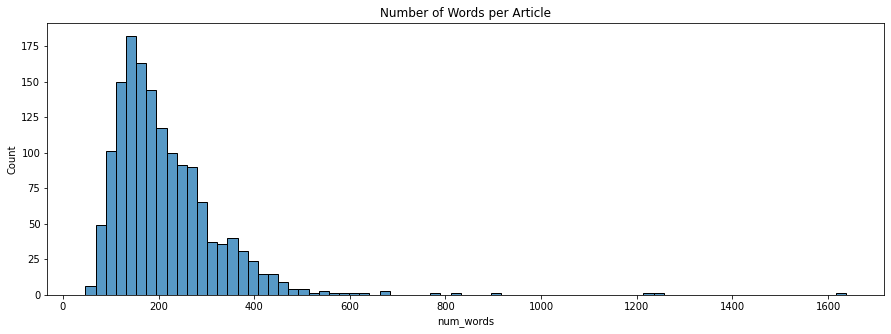

In [ ]:
# number of tokens (words) per article
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = train, 
    x = 'num_words',
    palette = 'colorblind',
    ).set(
        title = 'Number of Words per Article');

## 3d. Removing Outliers

**Removing Outlier Articles:** 

Articles that are longer than 750 words (Since we use summarization before classification, the articles that would be tested are in generally concise)

In [ ]:
train = train[train['num_words'] < 750]
len(train)

1484

## Graph 3

###**Graph displaying the Number of words per category in the training data set**

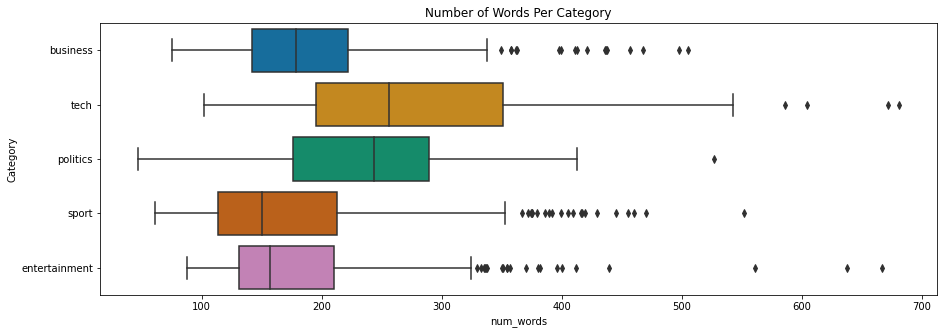

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(
    data = train, 
    x = 'num_words', 
    y = 'Category',
    palette = 'colorblind'
    ).set(
        title = 'Number of Words Per Category');

# Helper functions to Classify articles into categories

In [ ]:
train_df = train.copy()

In [ ]:
def predict(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [ ]:
def label_permute(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    perms = list(itertools.permutations([0, 1, 2, 3, 4]))    #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['business', 'tech', 'politics', 'sport', 'entertainment']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 5:
                conditions = [
                    (ytdf['Category'] == current['business']),
                    (ytdf['Category'] == current['tech']),
                    (ytdf['Category'] == current['politics']),
                    (ytdf['Category'] == current['sport']),
                    (ytdf['Category'] == current['entertainment'])]
                ytdf['test'] = ytdf['Category'].map(current)
                current_accuracy = accuracy_score(ytdf['test'], yp)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    ytdf['best'] = ytdf['test']
    return best_labels, best_acc

# Creating Vectorizer and NMF model

In [ ]:
#create vectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['clean_text'])

#create model
nmf_model = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy)

accuracy= 0.9609164420485176


Training accuracy for NMF using TF-IDF is found to be **96.09%**

In [ ]:
#show best labels for the trained model 
label_dict = {4:'business', 2:'tech', 1:'politics', 0:'sport', 3:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')

4:  business
2:  tech
1:  politics
0:  sport
3:  entertainment


# Test data classification with NMF & TF-IDF

In [ ]:
print(len(df))

64


In [ ]:
#first clean testing data as we did with the training data
for i in range(0,len(df)):
  test = df[i:i+1].copy()
  clean_text(test, 'summary')
  tfidvec_test = tfidvec.transform(test['clean_text'])
  yhat_test = predict(nmf_model.transform(tfidvec_test))
  test_predictions = pd.DataFrame(columns=['id', 'category', 'yhat'])
  test_predictions['id'] = test['id']
  test_predictions['yhat'] = yhat_test
  test_predictions['category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

  pred=test_predictions['category']
  df[i:i+1]['category']=pred
  print(pred)

0    politics
Name: category, dtype: object
1    politics
Name: category, dtype: object
2    politics
Name: category, dtype: object
3    politics
Name: category, dtype: object
4    politics
Name: category, dtype: object
5    business
Name: category, dtype: object
6    tech
Name: category, dtype: object
7    politics
Name: category, dtype: object
8    entertainment
Name: category, dtype: object
9    tech
Name: category, dtype: object
10    tech
Name: category, dtype: object


<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

11    tech
Name: category, dtype: object
12    entertainment
Name: category, dtype: object
13    politics
Name: category, dtype: object
14    business
Name: category, dtype: object
15    tech
Name: category, dtype: object
16    business
Name: category, dtype: object
17    business
Name: category, dtype: object
18    politics
Name: category, dtype: object
19    politics
Name: category, dtype: object
20    tech
Name: category, dtype: object
21    business
Name: category, dtype: object
22    business
Name: category, dtype: object


<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

23    entertainment
Name: category, dtype: object
24    entertainment
Name: category, dtype: object
25    business
Name: category, dtype: object
26    business
Name: category, dtype: object
27    politics
Name: category, dtype: object
28    tech
Name: category, dtype: object
29    business
Name: category, dtype: object
30    entertainment
Name: category, dtype: object
31    entertainment
Name: category, dtype: object
32    politics
Name: category, dtype: object
33    entertainment
Name: category, dtype: object
34    tech
Name: category, dtype: object
35    entertainment
Name: category, dtype: object


<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

36    politics
Name: category, dtype: object
37    business
Name: category, dtype: object
38    business
Name: category, dtype: object
39    entertainment
Name: category, dtype: object
40    politics
Name: category, dtype: object
41    politics
Name: category, dtype: object
42    politics
Name: category, dtype: object
43    sport
Name: category, dtype: object
44    tech
Name: category, dtype: object
45    politics
Name: category, dtype: object
46    business
Name: category, dtype: object
47    tech
Name: category, dtype: object
48    politics
Name: category, dtype: object
49    politics
Name: category, dtype: object


<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

50    politics
Name: category, dtype: object
51    tech
Name: category, dtype: object
52    tech
Name: category, dtype: object
53    entertainment
Name: category, dtype: object
54    politics
Name: category, dtype: object
55    business
Name: category, dtype: object
56    business
Name: category, dtype: object
57    tech
Name: category, dtype: object
58    politics
Name: category, dtype: object
59    politics
Name: category, dtype: object
60    politics
Name: category, dtype: object
61    tech
Name: category, dtype: object
62    tech
Name: category, dtype: object
63    politics
Name: category, dtype: object


<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+1]['category']=pred
<ipython-input-77-50b2471cd142>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [ ]:

clean_text(df, 'summary')
tfidvec_test = tfidvec.transform(df['clean_text'])
yhat_test = predict(nmf_model.transform(tfidvec_test))
#create a dataframe to store prediction outcomes
test_predictions = pd.DataFrame(columns=['id', 'category', 'yhat'])
test_predictions['id'] = df['id']
test_predictions['yhat'] = yhat_test
test_predictions['category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

pred=test_predictions['category']
df['category']=pred
print(pred)

0     politics
1     politics
2     politics
3     politics
4     politics
        ...   
59    politics
60    politics
61        tech
62        tech
63    politics
Name: category, Length: 64, dtype: object


In [ ]:
test = df.copy()

In [ ]:
clean_text(test, 'summary')
tfidvec_test = tfidvec.transform(test['clean_text'])
yhat_test = predict(nmf_model.transform(tfidvec_test))
#create a dataframe to save predicted outcomes
test_predictions = pd.DataFrame(columns=['id', 'category', 'yhat'])
test_predictions['id'] = test['id']
test_predictions['yhat'] = yhat_test
test_predictions['category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])


pred=test_predictions['category']
df.iloc[i]['category']=pred
print(pred)

0     politics
1     politics
2     politics
3     politics
4     politics
        ...   
59    politics
60    politics
61        tech
62        tech
63    politics
Name: category, Length: 64, dtype: object


/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [ ]:
pred

0     politics
1     politics
2     politics
3     politics
4     politics
        ...   
59    politics
60    politics
61        tech
62        tech
63    politics
Name: category, Length: 64, dtype: object

Test_Predictions variable below has the category that is predicted


It is found that the accuracy for test data predictions was around **96.32%** using NMF with TF-IDF vectorizer

Saving the test predictions to a csv file

In [ ]:
#save and submit test dataframe
try: 
    df.to_csv('classification(NMF).csv', index=False)
except: 
    pass

# 2nd model for classification : K-Means Clustering




## Importing Data

In [ ]:
#import data
train = pd.read_csv(train_path) 
test = pd.read_csv(projDataframe_path)

## Data Cleaning & Creating Vectorizer and K-means Model

In [ ]:
#clean data
clean_text(train, 'Text')

#split data into X and y
y_train = train['Category'].values
X_train = train['clean_text'].values

#create new vectorizer for supervised learning model
tfidfvec_supervised = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfSuper_train = tfidfvec_supervised.fit_transform(X_train) 

#create KMeans Model and train
kmeans = KMeans(n_clusters = 5, 
                init = 'k-means++', 
                algorithm = 'full', 
                random_state = 101)
yhat_train_super = kmeans.fit_predict(tfSuper_train)

#get accuracy
y_train_df = pd.DataFrame(y_train, columns=['Category'])
label_order, accuracy = label_permute(y_train_df, yhat_train_super)
print('accuracy=', accuracy)
print(label_order, '\n')

#show label order
label_dict = {3:'business', 1:'tech', 4:'politics', 2:'sport', 0:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')

accuracy= 0.9369127516778524
(3, 1, 0, 2, 4) 

3:  business
1:  tech
0:  entertainment
2:  sport
4:  politics


Training accuracy of K-means clustering with TF-IDF is found to be **93.69%**

# Testing data with K-means & TF-IDF

In [ ]:
#first clean testing data as we did with the training data

clean_text(test, 'summary')
tfSuper_test = tfidfvec_supervised.transform(test['clean_text'].values)
tfidvec_test = tfidvec.transform(test['clean_text'])
yhat_test = kmeans.predict(tfSuper_test)
test_predictions = pd.DataFrame(columns=['id', 'category', 'yhat'])
test_predictions['id'] = test['id']
test_predictions['yhat'] = yhat_test
test_predictions['category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])
pred=test_predictions['category']
df['category']=pred

Saving the test dataset predictions to a csv file

In [ ]:
#save and submit test dataframe
try: 
    df.to_csv('classification(KMeans).csv', index=False)
except: 
    pass

It is found out that the testing accuracy of K-means clustering with TF-IDF is only around **63%**

The low accuracy with K-means clustering supervised learning model could be due to overfitting of the data.